In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('sellers.csv', 'sellers')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Password',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\N Nisha\Desktop\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_descrip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# Connect to the MySQL database
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Password',
    database='ecommerce'
)

cursor = db.cursor()

  # E.Q1. List all unique cities where customers are located.

In [3]:
query = """SELECT DISTINCT customer_city FROM customers"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=['customer_city'])

print(df.head())

           customer_city
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


# E.Q2. Count the number of orders placed in 2017.


In [4]:
cursor.fetchall()
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cursor.execute(query)
data = cursor.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 225505)

# E.Q3. Find the total sales per category.


In [5]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,6.334233e+07
1,FURNITURE DECORATION,1.787720e+08
2,TELEPHONY,6.086026e+07
3,BED TABLE BATH,2.140692e+08
4,AUTOMOTIVE,1.065368e+08
...,...,...
69,CDS MUSIC DVDS,1.499288e+05
70,LA CUISINE,3.641912e+05
71,FASHION CHILDREN'S CLOTHING,9.820875e+04
72,PC GAMER,2.718038e+05


# E.Q4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end)/count(*))*100 from payments"""
cursor.execute(query)
data = cursor.fetchall()
"the percentage of orders that were paid in installments", data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# E.Q5. Count the number of customers from each state.


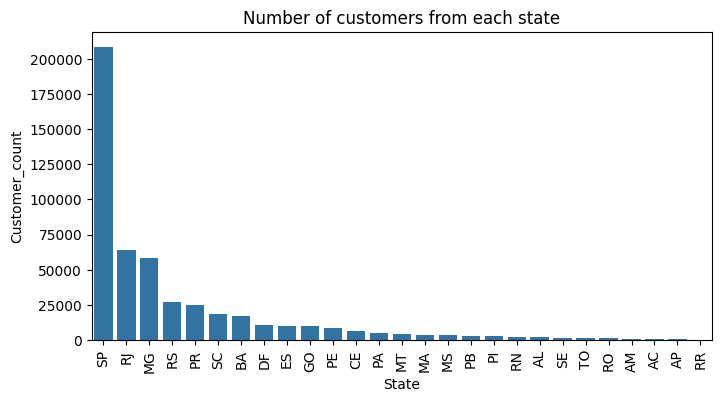

In [7]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=["State","Customer_count"])
df = df.sort_values(by = "Customer_count",ascending = False)
df = df.reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.title("Number of customers from each state")
sns.barplot(x=df["State"],y=df["Customer_count"])
plt.xticks(rotation=90)

plt.show()

# M.Q1. Calculate the number of orders per month in 2018.

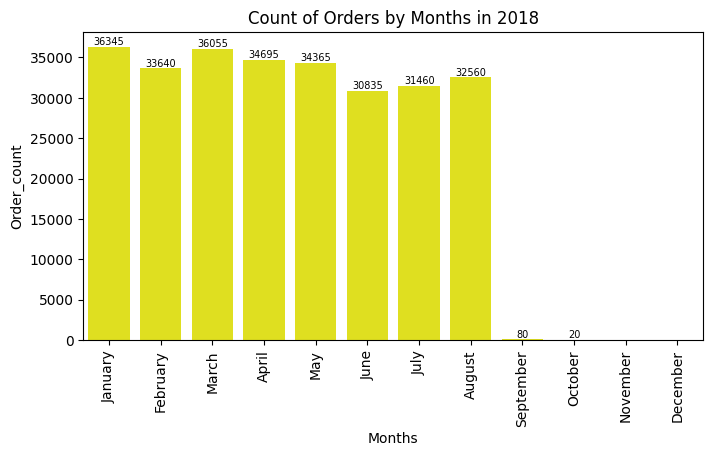

In [8]:
query = """ select monthname(order_purchase_timestamp) as months, count(order_id) as order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns =["Months","Order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October","November","December"]
ax = sns.barplot(x = df["Months"],y = df["Order_count"],data = df, order = o,color = "yellow")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0],fontsize=7)
plt.title("Count of Orders by Months in 2018")
ax.figure.set_size_inches(8, 4)
plt.show()

# M.Q2. Find the average number of products per order, grouped by customer city.

In [9]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Customer City", "Average Products/Order"])
df.head(10)

,Customer City,Average Products/Order
0,padre carvalho,175.00
1,celso ramos,162.50
2,datas,150.00
3,candido godoi,150.00
4,matias olimpio,125.00
5,cidelandia,100.00
6,curralinho,100.00
7,picarra,100.00
8,morro de sao paulo,100.00
9,teixeira soares,100.00


# M.Q3. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """select UPPER(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Category", "Percentage Distribution"])
df.head()

,Category,Percentage Distribution
0,BED TABLE BATH,267.44
1,HEALTH BEAUTY,258.82
2,COMPUTER ACCESSORIES,247.57
3,FURNITURE DECORATION,223.34
4,WATCHES PRESENT,223.19


# M.Q4. Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
import numpy as np

query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157564


# M.Q5. Calculate the total revenue generated by each seller, and rank them by revenue.

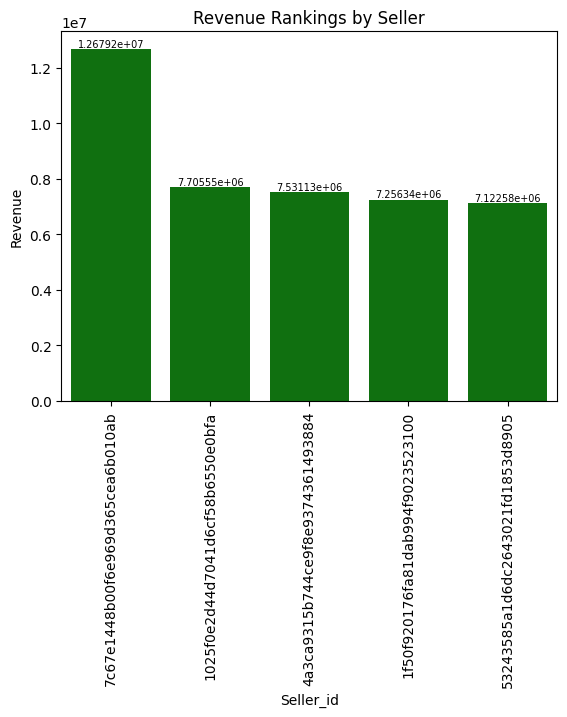

In [12]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) as revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Seller_id", "Revenue", "Rank"])
df = df.head()
ax = sns.barplot(x = "Seller_id", y = "Revenue", data = df,color="Green")
ax.bar_label(ax.containers[0],fontsize=7)
plt.title("Revenue Rankings by Seller")
plt.xticks(rotation = 90)
plt.show()

# A.Q1. Calculate the moving average of order values for each customer over their order history.

In [13]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Order id","Transaction Time","Payment","Moving Average"])
df.head(100)

,Order id,Transaction Time,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
95,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
96,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
97,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
98,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006


# A.Q2. Calculate the cumulative sales per month for each year.


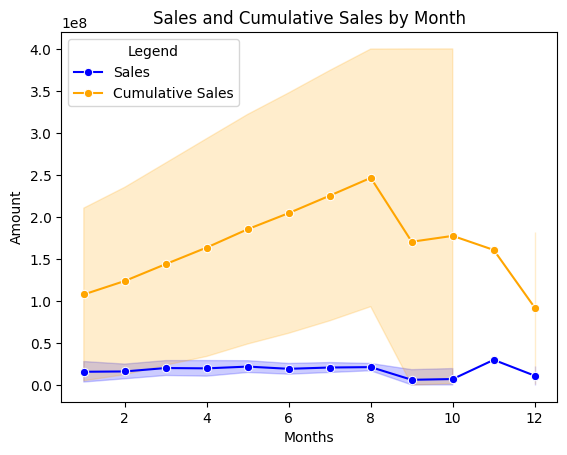

In [14]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data,columns=["Year","Months","Sales","Cumulative Sales"])
sns.lineplot(x='Months', y='Sales', data=df, marker='o', label='Sales', color='blue')
sns.lineplot(x='Months', y='Cumulative Sales', data=df, marker='o', label='Cumulative Sales', color='orange')
plt.title("Sales and Cumulative Sales by Month")
plt.xlabel("Months")
plt.ylabel("Amount")
plt.legend(title='Legend')
plt.show()

# A.Q3. Calculate the year-over-year growth rate of total sales.


In [15]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Years", "YOY Percentage Growth"])
df

,Years,YOY Percentage Growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# A.Q4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [16]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cursor.execute(query)
data = cursor.fetchall()

data

[(None,)]

# A.Q5. Identify the top 3 customers who spent the most money in each year.

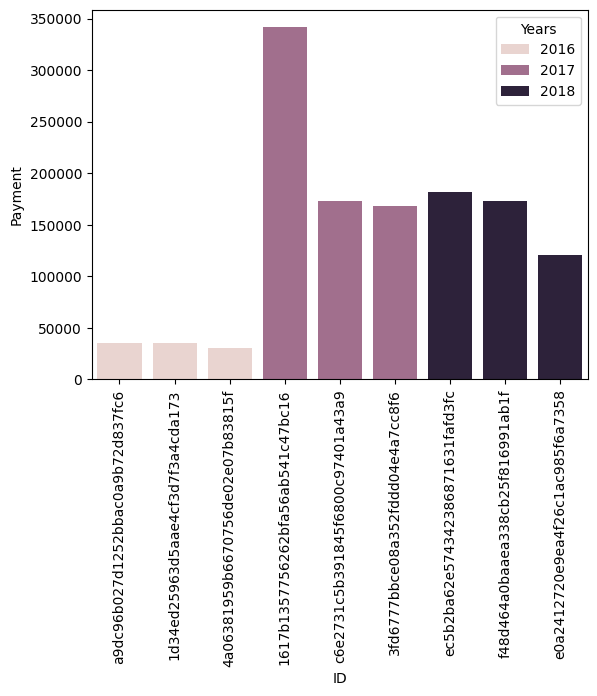

In [17]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Years","ID","Payment","Rank"])
sns.barplot(x = "ID", y = "Payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show()